### Paquetes necesarios

Para asegurar el correcto funcionamiento del notebook, primero importamos todos los paquetes necesarios. Estos incluyen herramientas para procesamiento de imágenes, manejo de archivos, cálculos matemáticos, gestión de rutas y tiempo, así como librerías específicas para detección de objetos y OCR.

In [1]:
import cv2  
import math 
import os
import shutil
import random
from pathlib import Path
import yaml
from ultralytics import YOLO
import pandas as pd
import time
import easyocr
import matplotlib.pyplot as plt


### Corrección del dataset

Este script se encarga de depurar el dataset para asegurar que solo las imágenes con sus etiquetas correspondientes se utilicen en el entrenamiento del modelo.  

Se define la ruta raíz del dataset y los splits existentes (`train`, `val`, `test`). También se especifican las extensiones de imagen válidas (`.jpg`, `.jpeg`, `.png`).  

Para cada split, el script revisa todas las imágenes y comprueba si existe un archivo de etiqueta asociado en la carpeta de labels. Las imágenes que no tengan su correspondiente archivo de etiqueta se mueven a una subcarpeta llamada `sin_labels`. Esto evita que el modelo reciba datos sin anotaciones durante el entrenamiento, lo que podría afectar negativamente su rendimiento.  

Al finalizar el proceso para cada split, se imprime un resumen indicando cuántas imágenes fueron movidas a la carpeta `sin_labels`.


In [ ]:
# ===== CONFIG =====
dataset_root = Path(r"C:\Users\Carlos Ruano\Downloads\VC_P4\TGC_RBNW")
splits = ["train", "val", "test"]
image_exts = [".jpg", ".jpeg", ".png"]

# ===== PROCESO =====
for split in splits:
    images_path = dataset_root / split / "images"
    labels_path = dataset_root / split / "labels"
    sin_labels_path = dataset_root / split / "sin_labels"
    sin_labels_path.mkdir(exist_ok=True)
    image_files = [f for f in images_path.iterdir() if f.suffix.lower() in image_exts]
    moved_count = 0
    for img in image_files:
        label_file = labels_path / f"{img.stem}.txt"
        if not label_file.exists():
            shutil.move(str(img), sin_labels_path / img.name)
            moved_count += 1

    print(f"[{split}] Imágenes movidas a sin_labels: {moved_count}")


### Eliminación de errores en los labels

En algunos archivos de etiquetas (`labels`) se detectó que ciertas clases estaban mal asignadas, usando un `1` en lugar de `0`. Dado que en nuestro proyecto solo nos interesa detectar matrículas, este paso corrige esos errores.  

El script recorre todos los archivos de etiquetas del split de prueba (`test/labels`). Para cada archivo, lee todas las líneas y reemplaza el primer valor de cada línea (que indica la clase del objeto) por `0`. Luego sobrescribe el archivo con las líneas corregidas. Si se desease corregir tambien la parte de train o val solo habria que cambiar la linea del path a la correcta.  

De esta forma, se garantiza que todas las anotaciones correspondan correctamente a la clase de interés, evitando posibles inconsistencias durante la evaluación del modelo.


In [ ]:
labels_path = Path(r"TGC_RBNW\test\labels")
for f in labels_path.glob("*.txt"):
    lines = f.read_text().splitlines()
    new_lines = []
    for l in lines:
        if l.strip():
            parts = l.split()
            parts[0] = "0"
            new_lines.append(" ".join(parts))
    f.write_text("\n".join(new_lines))


### Detección de matrícula, desenfoque y reconocimiento de texto

Este bloque realiza la detección de matrículas en un vídeo, aplica un desenfoque sobre ellas y extrae el texto usando OCR. El proceso se divide en varias etapas:

1. **Configuración inicial**:  
   Se definen las rutas del modelo YOLO entrenado, el vídeo de entrada, el vídeo de salida, el archivo CSV donde se guardarán los resultados y el tamaño del kernel de desenfoque.  

2. **Inicialización de modelos**:  
   Se carga el modelo YOLO para detección de matrículas y se inicializa EasyOCR para el reconocimiento de texto en las regiones detectadas.

3. **Procesamiento del vídeo**:  
   Se abre el vídeo de entrada y se obtiene información como el número de fotogramas por segundo y las dimensiones del vídeo. También se prepara un `VideoWriter` para guardar el vídeo resultante.

4. **Creación del CSV**:  
   Se define un DataFrame con columnas que almacenarán información por cada objeto detectado, incluyendo coordenadas, tipo de objeto, confianza, coordenadas de la matrícula y el texto reconocido.

5. **Iteración fotograma a fotograma**:  
   Para cada fotograma del vídeo:
   - Se realiza la detección de objetos con YOLO.
   - Para cada objeto detectado, se extraen las coordenadas y la clase.
   - Si el objeto es una matrícula:
     - Se aplica un padding a la región de interés para que el OCR no corte los bordes.
     - Se convierte a escala de grises y se aplica un umbral adaptativo para mejorar el reconocimiento.
     - Se ejecuta EasyOCR sobre la región, guardando el texto reconocido.
     - Posteriormente, se aplica un desenfoque Gaussiano sobre la matrícula en el fotograma.
   - Se dibujan rectángulos alrededor de todos los objetos detectados, diferenciando visualmente las matrículas.
   - Se almacena toda la información relevante en el DataFrame.

6. **Guardar resultados**:  
   - Se escribe cada fotograma procesado en el vídeo de salida.
   - Al finalizar, se guarda el DataFrame como CSV con toda la información de detección y OCR.

7. **Reporte final**:  
   Se calcula el tiempo promedio de inferencia por fotograma y se imprime un resumen con la ubicación del vídeo procesado y del CSV generado.


In [ ]:
import cv2
import time
import pandas as pd
from ultralytics import YOLO
import easyocr
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

import numpy as np

# ===== CONFIG =====
model_personas_coches_path = "yolo11n.pt"  # Modelo general
model_matriculas_path = "runs/detect/train/weights/best.pt"  # Modelo de matrículas
video_input = "Videos/C0142.MP4"
video_output = "Videos/video_resultado_final_blur.mp4"
csv_output = "CSVs/resultados_final_blur.csv"
blur_kernel = (25, 25)

# ===== Inicializar modelos =====
model_general = YOLO(model_personas_coches_path, verbose=False)
model_matriculas = YOLO(model_matriculas_path, verbose=False)

# ===== Inicializar OCR =====
reader = easyocr.Reader(['es'], gpu=True)

# ===== Abrir vídeo =====
cap = cv2.VideoCapture(video_input)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(video_output, fourcc, fps, (width, height))

# ===== DataFrames =====
columns = ["frame", "id_tracking", "tipo_objeto", "confianza", "x1","y1","x2","y2", "texto_matricula"]
df_easy = pd.DataFrame(columns=columns)
df_tesseract = pd.DataFrame(columns=columns)

# ===== Tracking =====
object_counts = {"person": 0, "car": 0, "matricula": 0}
unique_ids = set()

frame_idx = 0
tiempos = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_idx += 1
    start_time = time.time()

    # ===== 1️⃣ Detectar personas y coches =====
    results_general = model_general.track(frame, persist=True, classes=[0, 2])  # 0=person, 2=car

    if results_general:
        for r in results_general:
            boxes = r.boxes
            for box in boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf = float(box.conf[0])
                cls = int(box.cls[0])
                tipo = model_general.names[cls]
                track_id = int(box.id[0]) if box.id is not None else -1

                # Contar objetos únicos
                if track_id != -1 and (tipo, track_id) not in unique_ids:
                    object_counts[tipo] = object_counts.get(tipo, 0) + 1
                    unique_ids.add((tipo, track_id))

                # Blur a personas
                if tipo == "person":
                    roi = frame[y1:y2, x1:x2]
                    if roi.size != 0:
                        frame[y1:y2, x1:x2] = cv2.GaussianBlur(roi, blur_kernel, 0)

                # Dibujar cajas
                color = (0,255,0) if tipo=="person" else (255,165,0)
                etiqueta = f"{tipo.upper()} ID:{track_id}" if track_id!=-1 else tipo.upper()
                cv2.rectangle(frame, (x1,y1), (x2,y2), color, 2)
                cv2.putText(frame, etiqueta, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

                # Guardar en CSV
                df_easy = pd.concat([df_easy, pd.DataFrame([{
                    "frame": frame_idx, "id_tracking": track_id, "tipo_objeto": tipo,
                    "confianza": conf, "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                    "texto_matricula": ""
                }])], ignore_index=True)

    # ===== 2️⃣ Detectar matrículas =====
    results_matriculas = model_matriculas(frame)[0]
    for box in results_matriculas.boxes:
        cls_id = int(box.cls[0])
        tipo = model_matriculas.names[cls_id]
        if tipo.lower() != "matricula":
            continue

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        object_counts["matricula"] += 1

        # ROI con padding
        pad = 5
        y1_p, y2_p = max(0, y1-pad), min(frame.shape[0], y2+pad)
        x1_p, x2_p = max(0, x1-pad), min(frame.shape[1], x2+pad)
        roi = frame[y1_p:y2_p, x1_p:x2_p]

        texto_easy, texto_tess = "", ""
        if roi.size != 0 and roi.shape[1]>40 and roi.shape[0]>15:
            # Preprocesamiento
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            scale = 300 / roi_gray.shape[1]
            new_h = int(roi_gray.shape[0]*scale)
            roi_gray = cv2.resize(roi_gray, (300,new_h))
            roi_bin = cv2.adaptiveThreshold(roi_gray, 255,
                                            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, 11, 2)
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
            roi_bin = cv2.dilate(roi_bin, kernel, iterations=1)

            # OCR EasyOCR
            ocr_result = reader.readtext(roi_bin)
            texto_easy = "".join([r[1] for r in ocr_result])

            # OCR Tesseract
            config = "--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
            texto_tess = pytesseract.image_to_string(roi_bin, config=config)
            texto_tess = texto_tess.strip().replace(" ", "")

            # Aplicar blur
            frame[y1_p:y2_p, x1_p:x2_p] = cv2.GaussianBlur(roi, blur_kernel, 0)

        # Mostrar matrícula
        texto_final = texto_easy if texto_easy else "MATRICULA"
        cv2.rectangle(frame, (x1,y1),(x2,y2),(0,0,255),2)
        cv2.putText(frame, texto_final,(x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,0,255),2)

        # Guardar CSVs
        df_easy = pd.concat([df_easy, pd.DataFrame([{
            "frame": frame_idx, "id_tracking": "", "tipo_objeto": "matricula",
            "confianza": conf, "x1": x1, "y1": y1, "x2": x2, "y2": y2,
            "texto_matricula": texto_easy
        }])], ignore_index=True)

        df_tesseract = pd.concat([df_tesseract, pd.DataFrame([{
            "frame": frame_idx, "id_tracking": "", "tipo_objeto": "matricula",
            "confianza": conf, "x1": x1, "y1": y1, "x2": x2, "y2": y2,
            "texto_matricula": texto_tess
        }])], ignore_index=True)

    # ===== Contador global =====
    cv2.putText(frame, f"Personas: {object_counts['person']} | Coches: {object_counts['car']} | Matrículas: {object_counts['matricula']}",
                (20,40), cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)

    # Guardar frame
    out.write(frame)
    tiempos.append(time.time()-start_time)

# ===== Guardar CSVs y liberar recursos =====
df_easy.to_csv(csv_output, index=False)
csv_output_tess = csv_output.replace(".csv","_tesseract.csv")
df_tesseract.to_csv(csv_output_tess, index=False)

cap.release()
out.release()
cv2.destroyAllWindows()

# ===== Reporte =====
print("\n--- PROCESAMIENTO COMPLETADO ---")
print(f"Vídeo guardado en: {video_output}")
print(f"CSV EasyOCR guardado en: {csv_output}")
print(f"CSV Tesseract OCR guardado en: {csv_output_tess}")
print(f"Tiempo promedio de inferencia: {sum(tiempos)/len(tiempos):.4f}s/frame")
print("\nConteo total:")
for k,v in object_counts.items():
    print(f"  {k}: {v}")



0: 384x640 4 cars, 27.9ms
Speed: 6.0ms preprocess, 27.9ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 24.0ms
Speed: 4.4ms preprocess, 24.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


C:\Users\Carlos Ruano\AppData\Local\Temp\ipykernel_9960\640305353.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_easy = pd.concat([df_easy, pd.DataFrame([{



0: 384x640 4 cars, 25.9ms
Speed: 8.5ms preprocess, 25.9ms inference, 9.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 22.5ms
Speed: 4.8ms preprocess, 22.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 24.1ms
Speed: 5.0ms preprocess, 24.1ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 22.9ms
Speed: 4.8ms preprocess, 22.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 23.4ms
Speed: 8.7ms preprocess, 23.4ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 22.0ms
Speed: 4.9ms preprocess, 22.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 25.0ms
Speed: 5.0ms preprocess, 25.0ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 23.0ms
Speed: 6.0ms preprocess, 23.0ms inference, 4.3ms postprocess per imag

C:\Users\Carlos Ruano\AppData\Local\Temp\ipykernel_9960\640305353.py:145: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_tesseract = pd.concat([df_tesseract, pd.DataFrame([{



0: 384x640 2 persons, 2 cars, 16.6ms
Speed: 3.6ms preprocess, 16.6ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 matricula, 19.4ms
Speed: 3.6ms preprocess, 19.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 12.0ms
Speed: 4.1ms preprocess, 12.0ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 matricula, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 21.2ms
Speed: 4.1ms preprocess, 21.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 matricula, 20.2ms
Speed: 3.9ms preprocess, 20.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 cars, 12.7ms
Speed: 2.8ms preprocess, 12.7ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 matricula, 12.0ms
Speed: 2.6ms preprocess, 12.0ms inference, 1

### Detección de matrículas y extracción de texto en imágenes de test

Este bloque se encarga de procesar todas las imágenes de la carpeta de test, detectando matrículas, aplicando OCR y generando un CSV con los resultados. El flujo es el siguiente:

1. **Configuración inicial**:  
   Se definen las rutas del modelo YOLO entrenado, el directorio de imágenes de test y el archivo CSV de salida.

2. **Inicialización de modelos**:  
   Se carga el modelo YOLO para detección de matrículas y se inicializa EasyOCR para extraer el texto de las regiones detectadas.

3. **Preparación del CSV**:  
   Se crea un DataFrame vacío con columnas para almacenar el nombre de la imagen, tipo de objeto detectado, confianza, coordenadas de la caja delimitadora y el texto reconocido de la matrícula.

4. **Procesamiento de cada imagen**:  
   - Se recorre cada imagen del directorio de test.
   - Se ignoran archivos que no sean imágenes válidas.
   - Para cada imagen, se realiza la detección de objetos con YOLO.
   - Para cada objeto detectado:
     - Se extraen las coordenadas de la caja y la clase del objeto.
     - Si es una matrícula, se aplica un pequeño padding a la región para mejorar la precisión del OCR.
     - La región de la matrícula se convierte a escala de grises y se aplica un umbral adaptativo.
     - Se ejecuta EasyOCR para extraer el texto de la matrícula.
   - Se guarda toda la información en el DataFrame.

5. **Guardar resultados**:  
   - Al finalizar el procesamiento de todas las imágenes, se exporta el DataFrame completo a un archivo CSV.
   - Se imprime la ubicación del CSV generado para su revisión.


In [3]:
# ===== CONFIG =====
model_path = "runs/detect/train/weights/best.pt"
test_dir = "TGC_RBNW/test/images"
csv_output = "CSVs/matriculas_test.csv"

# ===== Inicializar YOLO =====
model = YOLO(model_path)

# ===== Inicializar EasyOCR =====
reader = easyocr.Reader(['es'], gpu=True)

# ===== Preparar DataFrame =====
columns = ["imagen","tipo_objeto","confianza",
           "x1","y1","x2","y2","texto_matricula"]
df = pd.DataFrame(columns=columns)

# ===== Procesar todas las imágenes =====
for filename in os.listdir(test_dir):
    if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    image_path = os.path.join(test_dir, filename)
    frame = cv2.imread(image_path)
    if frame is None:
        continue

    results = model(frame)[0]

    for box in results.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        tipo = model.names[cls_id]

        texto_matricula = ""
        if tipo.lower() == "matricula":
            pad = 5
            y1_p, y2_p = max(0, y1-pad), min(frame.shape[0], y2+pad)
            x1_p, x2_p = max(0, x1-pad), min(frame.shape[1], x2+pad)
            roi = frame[y1_p:y2_p, x1_p:x2_p]

            if roi.size != 0:
                # OCR
                roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
                _, roi_thresh = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                ocr_result = reader.readtext(roi_thresh)
                if ocr_result:
                    texto_matricula = " ".join([r[1] for r in ocr_result])

        # Guardar info en DataFrame
        df = pd.concat([df, pd.DataFrame([{
            "imagen": filename,
            "tipo_objeto": tipo,
            "confianza": conf,
            "x1": x1, "y1": y1, "x2": x2, "y2": y2,
            "texto_matricula": texto_matricula
        }])], ignore_index=True)

# ===== Guardar CSV =====
df.to_csv(csv_output, index=False)
print(f"CSV de matrículas generado en: {csv_output}")



0: 640x320 1 matricula, 101.4ms
Speed: 8.3ms preprocess, 101.4ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 320)



C:\Users\Carlos Ruano\AppData\Local\Temp\ipykernel_27920\3676167963.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{


0: 480x640 1 matricula, 110.0ms
Speed: 10.8ms preprocess, 110.0ms inference, 7.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 matricula, 21.1ms
Speed: 11.4ms preprocess, 21.1ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 matricula, 83.5ms
Speed: 4.8ms preprocess, 83.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 matricula, 25.5ms
Speed: 4.5ms preprocess, 25.5ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 1 matricula, 22.9ms
Speed: 4.0ms preprocess, 22.9ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 640)

0: 640x384 1 matricula, 19.3ms
Speed: 3.5ms preprocess, 19.3ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 matricula, 15.3ms
Speed: 3.3ms preprocess, 15.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 1 matricula, 25.2ms
Speed: 6.3ms preprocess, 25.2ms inference, 4.2ms postprocess p


0: 640x480 1 matricula, 58.7ms
Speed: 8.9ms preprocess, 58.7ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 480)
[test.jpeg] Texto detectado: LI79HFR


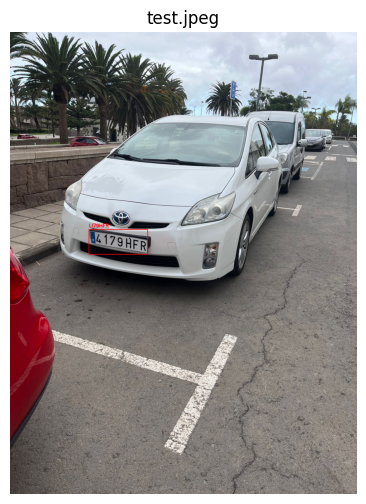


0: 640x480 1 matricula, 25.0ms
Speed: 8.4ms preprocess, 25.0ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 480)
[test2.jpeg] Texto detectado: 4179HFR


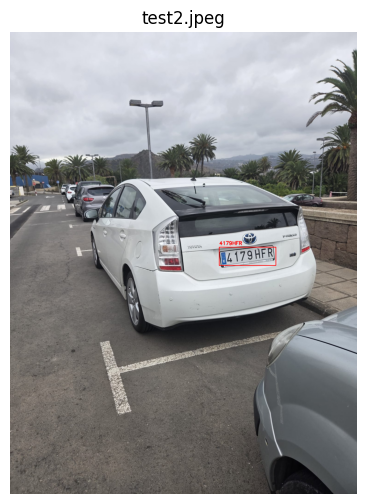

In [3]:
import cv2
from ultralytics import YOLO
import easyocr
import matplotlib.pyplot as plt

# ===== CONFIG =====
model_path = "runs/detect/train/weights/best.pt"
image_paths = ["test.jpeg", "test2.jpeg"]

# ===== Inicializar YOLO =====
model = YOLO(model_path)

# ===== Inicializar EasyOCR =====
reader = easyocr.Reader(['es'], gpu=True)

# ===== Procesar cada imagen =====
for image_path in image_paths:
    # Cargar imagen
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"No se pudo cargar la imagen {image_path}")
        continue

    # Detección
    results = model(frame)[0]

    # Procesar detecciones
    for box in results.boxes:
        cls_id = int(box.cls[0])
        tipo = model.names[cls_id]
        if tipo.lower() == "matricula":
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # Padding
            pad = 5
            y1_p, y2_p = max(0, y1-pad), min(frame.shape[0], y2+pad)
            x1_p, x2_p = max(0, x1-pad), min(frame.shape[1], x2+pad)
            roi = frame[y1_p:y2_p, x1_p:x2_p]

            # OCR
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            _, roi_thresh = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            ocr_result = reader.readtext(roi_thresh)
            texto_matricula = " ".join([r[1] for r in ocr_result]) if ocr_result else ""
            print(f"[{image_path}] Texto detectado:", texto_matricula.strip().replace(" ", ""))

            # Dibujar recuadro
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0,0,255), 2)
            cv2.putText(frame, texto_matricula.strip().replace(" ", ""), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    # Mostrar imagen con matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    plt.title(image_path)
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.show()
